# Import Libraries and Load Data 

First of all we import the libraries needed to work in this project, we load the train and test datasets  and we show the first 5 rows of each column 

In [549]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer


data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price
0,9255,1.00,1.00,NaN,NaN,1956.00,3º - 1a,False,False,Sant Martí,2.00,True,True,NaN,1096
1,1562,4.00,1.00,133.00,west,1960.00,7º - 2a,False,False,Sants,4.00,False,False,2.00,1396
2,1671,2.00,3.00,137.00,NaN,2000.00,1º - 1a,False,True,Eixample,0.00,False,False,NaN,1263
3,6088,1.00,2.00,-41.00,NaN,2002.00,6º - 1a,False,True,Sants,5.00,False,False,NaN,1290
4,6670,2.00,1.00,70.00,NaN,1979.00,5º - 1a,True,False,Gràcia,0.00,False,True,3.00,962


First check the data how it looks like, what features do we have to work with and what type (categorical or numerical) they are 

In [550]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


Then we check the missing values in our dataset, and as one can see too many num_supermarkets values are missing

In [1]:
# missing_values_in_data = data.isnull().sum()
# missing_values_in_data

Moreover, we use data.describe() to check our data, and see the minimums and maximums of the data for each column that will be useful to see the outliers of our dataset

In [551]:
data.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.00,8000.00,7840.00,7845.00,7830.00,7840.00,1411.00,8000.00
mean,5012.51,2.87,1.99,108.03,1985.32,2.80,1.98,1099.62
std,2887.65,5.30,0.82,38.67,20.59,3.45,0.80,271.69
min,2.00,1.00,1.00,-100.00,1950.00,0.00,1.00,195.00
25%,2512.75,1.00,1.00,78.00,1968.00,0.00,1.00,905.75
50%,5014.50,2.00,2.00,110.00,1985.00,1.00,2.00,1104.00
75%,7505.25,4.00,3.00,140.00,2003.00,6.00,3.00,1295.00
max,10000.00,97.00,3.00,170.00,2021.00,10.00,3.00,2095.00


Neither of the columns has_ac, has_pool, is_furnished, accepts_pets and orientation seem to be too relevant

In [552]:
print(data.groupby('has_ac')['price'].mean().reset_index())
print(data.groupby('is_furnished')['price'].mean().reset_index())
print(data.groupby('has_pool')['price'].mean().reset_index())
print(data.groupby('accepts_pets')['price'].mean().reset_index())
print(data.groupby('orientation')['price'].mean().reset_index())

   has_ac   price
0   False 1101.19
1    True 1097.17
   is_furnished   price
0         False 1097.81
1          True 1101.77
   has_pool   price
0     False 1099.16
1      True 1099.74
   accepts_pets   price
0         False 1102.95
1          True 1097.18
  orientation   price
0        east 1093.64
1       north 1096.45
2       south 1102.29
3       soxth  904.00
4        west 1098.56


# Data cleaning

Now we are going to start cleaning the data.
1. we are going to drop the number of supermarkets column beacause a lot of rows are missing
2. We are going to put NaN in extreme values in the square meters and rooms columns to improve the statistical accuracy when doing the testing part 
3. We drop rows with 2 or more NaN values between columns (square meters, number of rooms, number of baths, year built and neighborhood), beacause is better to delete any row if a important part of the information for the testing part is missing
4. We take the door column and we just take the floor part from this column as it seems the only relevant part of this columns

In [553]:
# Drop Supermarket column and put NaN in extreme values of sqr_mts and rooms
cleaned_data = data.drop(columns='num_supermarkets')
cleaned_data['square_meters'] = np.where(cleaned_data['square_meters']<0, np.NaN, cleaned_data['square_meters'])
cleaned_data['num_rooms'] = np.where(cleaned_data['num_rooms']>6, np.NaN, cleaned_data['num_rooms'])

# Fix orientation
cleaned_data['orientation'] = np.where(cleaned_data['orientation']=='soxth', 'south', cleaned_data['orientation'])

# Check for missing data in more than 1 of these columns
columns_to_check=['square_meters', 'num_rooms', 'num_baths', 'year_built', 'neighborhood']
rows_with_missing_values = cleaned_data[cleaned_data[columns_to_check].isnull().sum(axis=1) >= 2]

# Drop rows with 2 or more NaN values in columns_to_check
cleaned_data = cleaned_data.drop(rows_with_missing_values.index)

# Add floor and door_nbr
cleaned_data['floor'] = cleaned_data['door'].str.extract(r'(\d+)º')
cleaned_data['floor'] = pd.to_numeric(cleaned_data['floor'], errors='coerce').convert_dtypes()
cleaned_data.reset_index(inplace=True)
cleaned_data = cleaned_data.drop(columns=['door','index'])
cleaned_data.head()
# cleaned_data.info()

,id,num_rooms,num_baths,square_meters,orientation,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor
0,9255,1.00,1.00,NaN,NaN,1956.00,False,False,Sant Martí,2.00,True,True,1096,3
1,1562,4.00,1.00,133.00,west,1960.00,False,False,Sants,4.00,False,False,1396,7
2,1671,2.00,3.00,137.00,NaN,2000.00,False,True,Eixample,0.00,False,False,1263,1
3,6088,1.00,2.00,NaN,NaN,2002.00,False,True,Sants,5.00,False,False,1290,6
4,6670,2.00,1.00,70.00,NaN,1979.00,True,False,Gràcia,0.00,False,True,962,5


Then we check the average price of housing per neighborhood and we can see there is some difference in the price values depending on each neighborhood

In [554]:
neigh_data = cleaned_data.groupby('neighborhood').agg({'price':np.mean})
neigh_data.sort_values('price', ascending=False)

,price
neighborhood,
Sarrià-Sant Gervasi,1153.04
Eixample,1143.38
Les Cors,1126.51
Gràcia,1116.98
Horta,1108.24
Ciutat Vella,1096.88
Sants,1087.79
Sant Martí,1067.89
Sant Andreu,1067.31


Therefore, we create a mapping to group the neigborhood in 3 groups depending of their mean price to change this column from a categorical to a numerical column

In [555]:
# Create a mapping for the 'neighborhood' column grouping them in order
neighborhood_mapping = {
    'Sarrià-Sant Gervasi': 3,
    'Eixample': 3,
    'Les Cors' : 3,
    'Gràcia': 2,
    'Horta': 2,
    'Ciutat Vella' : 2,
    'Sants': 2,
    'Sant Andreu': 1,
    'Sant Martí' : 1,
    'Nou Barris': 1
}
cleaned_data['neighborhood'] = cleaned_data['neighborhood'].map(neighborhood_mapping)
cleaned_data.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor
0,9255,1.00,1.00,NaN,NaN,1956.00,False,False,1.00,2.00,True,True,1096,3
1,1562,4.00,1.00,133.00,west,1960.00,False,False,2.00,4.00,False,False,1396,7
2,1671,2.00,3.00,137.00,NaN,2000.00,False,True,3.00,0.00,False,False,1263,1
3,6088,1.00,2.00,NaN,NaN,2002.00,False,True,2.00,5.00,False,False,1290,6
4,6670,2.00,1.00,70.00,NaN,1979.00,True,False,2.00,0.00,False,True,962,5


# Plot to visually analize relationships between columns

In [556]:
# # Create pairplots to visually analyze relationships
sns.pairplot(cleaned_data[['num_rooms',	'num_baths','square_meters','year_built','num_crimes','neighborhood','floor','price']])

In the following correlation matrix, we can discern the relationships between different variables. Notably, the variable with the most correlations is the price.

Upon examining this variable, it becomes evident that it exhibits a positive correlation with square meters, neighborhood, floor, number of rooms, and number of baths. Conversely, it shows a slight negative correlation with the number of crimes and year built.

Delving deeper into these correlations, square meters emerges as the most strongly correlated variable in absolute terms, followed by the number of crimes. This aligns with economic rationale; people place substantial value on the overall size of a house and are averse to residing in areas with higher crime rates. Moreover, regions affected by higher criminal activity often coincide with lower-income areas and inadequate infrastructure, further indicating reasons for the decreased property prices.

This insight is reinforced by another correlation identified in the matrix—the negative correlation between the number of crimes and the neighborhood. This correlation appears logical as there might be confounding factors driving these effects, such as lower income, poor infrastructure, and segregated populations.

However, it's crucial to note that while this correlation is present, it won't impact the subsequent estimations. This could potentially indicate the presence of multicollinearity. Multicollinearity happens when predictor variables in a model are highly correlated, making it difficult to estimate individual effects accurately. Importantly, multicollinearity does not hinder the accurate estimation of joint effects. When these variables are considered together, accurate predictions regarding their combined impact can be made; it's just the separate estimations that may be affected.

In the code's appendix, you'll discover an Ordinary Least Squares (OLS) estimation. This estimation provides akin information, delving deeper by evaluating the statistical significance of the variables associated with the price. This additional analysis enhances our confidence in proceeding with our comprehensive analysis.

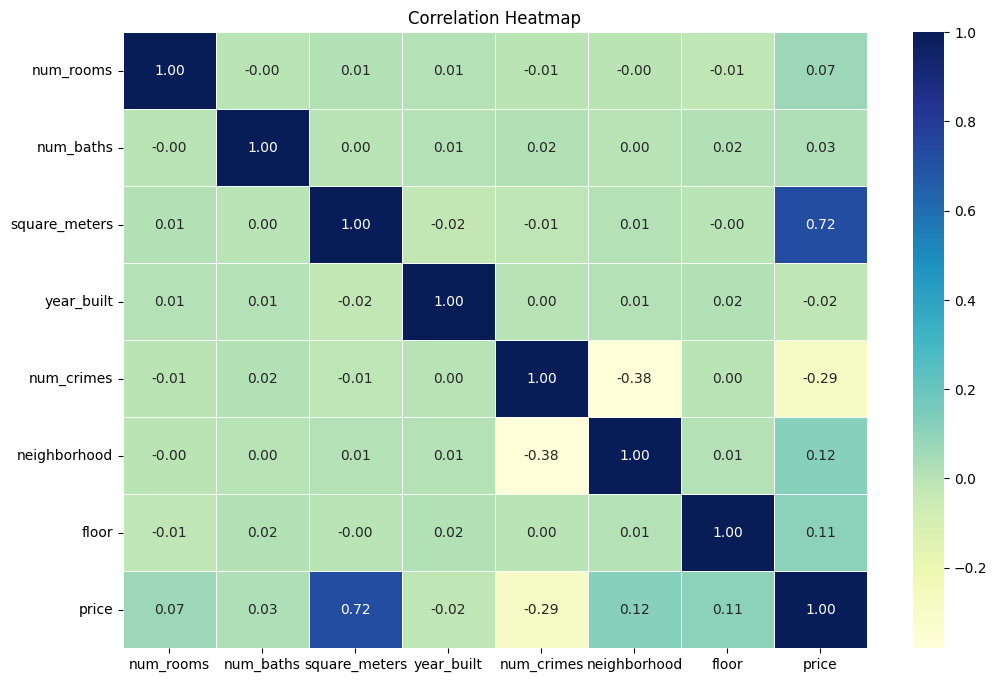

In [ ]:
# Create a correlation matrix and heatmap
correlation_matrix = cleaned_data[['num_rooms',	'num_baths','square_meters','year_built','num_crimes','neighborhood','floor','price']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

Upon prior examination, it became evident that the price variable suffers from distribution issues due to notable outliers, potentially impacting its predictability. One effective approach to address this is winsorization (definition of winsorization).

Since the estimation will center on predicting prices, it's crucial to recognize that outliers might skew the predicted values, consequently biasing our predictors. Although these outlier values are limited in number, their influence could jeopardize the accuracy of the overall estimation.

In [ ]:
# Use Winsorizer for extreme values
capper = Winsorizer(capping_method = 'gaussian',
                    #Which tail to cap values, here I choose the right tail to cap high values
                    tail = 'both',
                    #Fold indicates the number of standard deviations
                    fold = 3,
                    variables = ['price'])

#Fit the capper to the data
capper.fit(cleaned_data)
#Cap extreme values in the data
cleaned_data = capper.transform(cleaned_data)

# Testing the Dataset

"Neighborhood" is a categorical variable determined by geographical positioning, making it non-numeric and unsuitable for estimation via traditional statistical methods such as average or median calculations. Additionally, it encompasses several factors influencing neighborhood designation.

To enhance the estimation of missing neighborhood values, approximately 20% of the original dataset, a decision was made to employ an ML Black Box model, specifically the Random Forest Classifier. This model leverages various characteristics to predict these missing neighborhood values.

Moreover, considering that neighborhood significantly impacts the price, it's crucial to accurately predict it using the best possible methods available.

In [560]:
# Split the data into two sets: one with missing values and one without for neighborhood
data_missing = cleaned_data[cleaned_data['neighborhood'].isnull()]
data_not_missing = cleaned_data.dropna(subset=['neighborhood','num_rooms', 'square_meters', 'num_baths', 'year_built', 'price'])

# Define features and target variable
X = data_not_missing[['num_rooms', 'square_meters', 'num_baths', 'year_built', 'price']]
y = data_not_missing['neighborhood']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=220)

# Train a RandomForestClassifier to predict "neighborhood"
model = RandomForestClassifier(random_state=220)
model.fit(X_train, y_train)

# Predict the missing values
predicted_neighborhood = model.predict(data_missing[['num_rooms', 'square_meters', 'num_baths', 'year_built', 'price']])

# Fill in the missing values in the original DataFrame
cleaned_data.loc[cleaned_data['neighborhood'].isnull(), 'neighborhood'] = predicted_neighborhood
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7965 entries, 0 to 7964
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7965 non-null   int64  
 1   num_rooms      7922 non-null   float64
 2   num_baths      7823 non-null   float64
 3   square_meters  7750 non-null   float64
 4   orientation    5632 non-null   object 
 5   year_built     7811 non-null   float64
 6   is_furnished   7800 non-null   object 
 7   has_pool       7812 non-null   object 
 8   neighborhood   7965 non-null   float64
 9   num_crimes     7807 non-null   float64
 10  has_ac         7797 non-null   object 
 11  accepts_pets   7810 non-null   object 
 12  price          7965 non-null   float64
 13  floor          7816 non-null   Int64  
dtypes: Int64(1), float64(7), int64(1), object(5)
memory usage: 879.1+ KB


The missing values are generally low across the dataset, with the exception of orientation, which notably lacks substantial data. However, our earlier analysis indicated that orientation doesn't significantly impact our predicted variable, price.

Consequently, we've opted to employ the K-Nearest Neighbors (KNN) method to impute these missing orientation values. This method utilizes the available characteristics and the known values to estimate and fill in the missing orientation data.

In [561]:
# Create KNNImputer object with k=6 to fill the rest of the missing data
imputer = KNNImputer(n_neighbors=6)

# Perform KNN imputation
imputed_data = imputer.fit_transform(cleaned_data[['id', 'num_rooms', 'num_baths', 'square_meters',
    'year_built', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes',
    'has_ac', 'accepts_pets', 'price', 'floor']])

# Convert the imputed data back to DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=cleaned_data[['id', 'num_rooms', 'num_baths', 'square_meters',
    'year_built', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes',
    'has_ac', 'accepts_pets', 'price', 'floor']].columns)


We will perform an accurate estimation of the predictors for our model by consolidating the most available data. This involves merging the data for training and testing to ensure the most accurate estimation in each interpolation process. Furthermore, we apply the cleaning methods used on our training dataset to ensure accurate estimations.

To summarize the steps:
1. We remove the variables "supermarkets" and "orientations" as previous analysis indicated their inefficacy.
2. The "floor" variable is created, through the "door" variable, extracting the relevant information.
3. "Door" and the previous index are dropped.
4. (What is the goal of mapping the neighborhood?).
5. We merge the previously cleaned data with the final imputed training data, incorporating all cleaning processes.
6. Negative values are eliminated and replaced with the mean of the overall set. Additionally, extreme values of rooms, considered outliers and not based on reality, are adjusted.
7. Missing values for "num_rooms," "square meters," "num_baths," and "year_built" are imputed using the forward fill method, sorted by square meters. This method is logical as it's expected that the number of rooms is similar in observations with similar square meters.
8. The same approach is applied to estimate missing neighborhood data. Houses in a neighborhood are anticipated to share similar characteristics, and therefore, using these features helps estimate missing values. Although neighborhoods might not be directly correlated with price, they tend to develop over similar time spans, allowing for estimations based on that premise. Subsequently, the index is reset, and we assess the estimated data.

In [562]:
# Drop Supermarket and Orientation column
cleaned_td = test_data.drop(columns=['num_supermarkets','orientation'])

# Add floor and door_nbr
cleaned_td['floor'] = cleaned_td['door'].str.extract(r'(\d+)º')
cleaned_td['floor'] = pd.to_numeric(cleaned_td['floor'], errors='coerce').convert_dtypes()
cleaned_td.reset_index(inplace=True)
cleaned_td = cleaned_td.drop(columns=['door','index'])

#Map Neighborhood
cleaned_td['neighborhood'] = cleaned_td['neighborhood'].map(neighborhood_mapping)

# Join with previous data
total_data = pd.concat([imputed_data, cleaned_td])
total_data['square_meters'] = np.where(total_data['square_meters']<0, np.NaN, total_data['square_meters'])
total_data['square_meters'] = total_data['square_meters'].fillna(total_data['square_meters'].mean())
total_data['num_rooms'] = np.where(total_data['num_rooms']>6, np.NaN, total_data['num_rooms'])

# Fill missing data in rooms, baths and year by sorting sqr_mts and using ffill
total_data.sort_values('square_meters', inplace=True)
total_data[['num_rooms', 'square_meters', 'num_baths', 'year_built']] = total_data[['num_rooms', 'square_meters', 'num_baths', 'year_built']].ffill()

# Fill missing data in neighborhood and orientation by sorting other values and using ffill
total_data.sort_values(['year_built', 'num_rooms', 'square_meters', 'num_baths'], inplace=True)
total_data[['neighborhood']] = total_data[['neighborhood']].ffill()
total_data.reset_index(inplace=True, drop=True)
total_data.head()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor
0,9290.00,1.00,1.00,50.00,1950.00,0.00,1.00,2.00,5.00,1.00,0.00,294.00,7.00
1,5366.00,1.00,3.00,57.00,1950.00,1.00,1.00,2.00,0.00,0.00,0.00,920.00,5.00
2,5455.00,1.00,2.00,58.00,1950.00,False,True,2.00,3.00,True,False,NaN,6.00
3,7641.00,1.00,3.00,60.00,1950.00,True,True,2.00,9.00,False,True,NaN,8.00
4,1990.00,1.00,1.00,64.00,1950.00,0.00,0.00,3.00,0.00,0.00,1.00,933.00,4.00


Currently, our dataset has very few missing values, ensuring that all variables are sufficiently filled. This completion allows us to proceed with further iterations and analyses using comprehensive data.

In [564]:
# Create KNNImputer object with k=6 to fill the missing data
imputer = KNNImputer(n_neighbors=6)

# Perform KNN imputation
imputed_td = imputer.fit_transform(total_data[['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built',
    'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac',
    'accepts_pets', 'floor']])

# Convert the imputed data back to DataFrame
imputed_td = pd.DataFrame(imputed_td, columns=total_data[['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built',
    'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac',
    'accepts_pets', 'floor']].columns)

# Approximate values to True or False
imputed_td[['is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']] = imputed_td[['is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']].round()
imputed_td = imputed_td.join(total_data[['id', 'price']].set_index('id'), on='id', rsuffix='_total', how='left')


We standardized the variables before estimating the house prices in Barcelona. The goal behind this standardization process is to ensure that all the features are on a similar scale. Given that we're aiming to predict house prices, it's crucial to have our variables standardized to prevent any one feature from disproportionately influencing the model due to differences in their original scales.

The provided code allowed us to standardize various features such as the number of rooms, number of baths, square meters, neighborhood, number of crimes, floor, and year built. By bringing these variables to a common scale, we're helping the model converge more efficiently and improve its performance in estimating house prices accurately.

In [565]:
# Standardize values
imputed_td['num_rooms'] = (imputed_td['num_rooms'] - np.mean(imputed_td['num_rooms'])) / np.std(imputed_td['num_rooms'])
imputed_td['num_baths'] = (imputed_td['num_baths'] - np.mean(imputed_td['num_baths'])) / np.std(imputed_td['num_baths'])
imputed_td['square_meters'] = (imputed_td['square_meters'] - np.mean(imputed_td['square_meters'])) / np.std(imputed_td['square_meters'])
imputed_td['neighborhood'] = (imputed_td['neighborhood'] - np.mean(imputed_td['neighborhood'])) / np.std(imputed_td['neighborhood'])
imputed_td['num_crimes'] = (imputed_td['num_crimes'] - np.mean(imputed_td['num_crimes'])) / np.std(imputed_td['num_crimes'])
imputed_td['floor'] = (imputed_td['floor'] - np.mean(imputed_td['floor'])) / np.std(imputed_td['floor'])
imputed_td['year_built'] = (imputed_td['year_built'] - np.mean(imputed_td['year_built'])) / np.std(imputed_td['year_built'])

The final estimation code went through several iterations, incorporating economic insights drawn from the statistical significance found in the Appendix. This fusion enabled us to blend the best machine learning practices with valuable economic principles.

We identified variables that possess a more substantial impact on price. However, to attain the most accurate estimation with minimal fluctuations, we arrived at these specific variables. that optimize our Mean Squared Error (MSE).

These values exhibit greater variation and are notably non-binary, which we discovered through the iterative process.

In [566]:
# Predicting Values
# Separate data from test
cleaned_test = imputed_td[imputed_td['price'].isnull()]
cleaned_data = imputed_td.dropna(subset=['price'])

# Define features and target
# feature_columns=['num_rooms', 'num_baths', 'square_meters', 'year_built',
#     'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets',
#     'floor', 'neighborhood']
feature_columns=['num_rooms', 'num_baths', 'square_meters', 'num_crimes', 'floor', 'neighborhood']
X = cleaned_data[feature_columns]
y = cleaned_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

We are utilizing LazyRegressor to determine the best estimator for our project, which involves estimating house prices in Barcelona. This tool enables us to swiftly evaluate and compare various regression models without requiring extensive manual configuration or fine-tuning.

With LazyRegressor, we can efficiently assess a wide array of regression models, including Linear Regression, Decision Tree Regression, Random Forest Regression, Gradient Boosting Regression, and others. This broad model comparison helps in identifying which models hold the most promise for our specific dataset without the need for in-depth parameter tuning, making it an ideal starting point for our analysis.

Our objective is to quickly identify the most suitable regression models that can potentially provide the most accurate predictions for house prices in Barcelona. Subsequently, we can focus our efforts on refining and optimizing these models further for improved performance.

In [567]:
# Use LazyRegressor for automatic model selection and evaluation
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display the models and their performance metrics
print(models)

# The predictions DataFrame contains the predicted values from various models
print(predictions)

100%|██████████| 42/42 [00:20<00:00,  2.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 6372, number of used features: 6
[LightGBM] [Info] Start training from score 1101.391430
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
Lasso                                        0.64       0.64  159.70   
LassoLars                                    0.64       0.64  159.70   
LassoCV                                      0.64       0.64  159.70   
LassoLarsCV                                  0.64       0.64  159.70   
LarsCV                                       0.64       0.64  159.70   
BayesianRidge                                0.64       0.64  159.70   
RidgeCV           

Here we will need test to correctly identify the alpha.

In [568]:
# Choose the best model (in this case, RidgeCV)
alphas = [0.1, 1.0, 10.0]
best_model = Lasso(alpha=1)
best_model.fit(X, y)

cleaned_test['price'] = best_model.predict(cleaned_test[feature_columns])

# Export cleaned_test id and prices rounded and without decimals to a csv
cleaned_test[['id','price']].astype(int).to_csv('sub3.csv', index=False)

# APPPENDIX

The following code below represents an earlier exploration performed by a team member aimed at identifying variables impacting the house prices. The key contribution involves conducting an Ordinary Least Squares (OLS) regression analysis to determine the significance of the presented variables.

The OLS regression reveals that variables such as num_rooms, num_baths, square meters, num_crimes, and all neighborhoods except Sants, Sant Marti, and Sant Andreu exhibit significant values at a 1% significance level. Their respective p-values are 0.014, 0.021, and 0.013, indicating significance even at lower significance thresholds like 3%.

Upon conducting a significance test on these variables, the analysis suggests they are statistically significant, as the null hypothesis (Beta=0) is rejected. This implies that these estimators hold substantial predictive power over our dependent variable, price.

Conversely, the binary variables demonstrate notably high p-values, suggesting significance only at extremely low p-values. This indicates that they might not serve as effective estimators and could potentially contribute noise if included in the estimates, as they are less determinant concerning price.

In [16]:
import pandas as pd
import statistics
import numpy as np  

df=pd.read_csv("/Users/ruimaciel/Desktop/Barcelona/Machine_Learning/train.csv")

In [17]:
"""Function to give missing information overall"""
def calculate_missing_info(df):
    def calculate_percentage_with_missing(df, num_missing):
        total_rows = len(df)
        rows_with_missing = (df.isnull().sum(axis=1) == num_missing).sum()
        percentage_missing = (rows_with_missing / total_rows) * 100
        return rows_with_missing, percentage_missing

    total_rows = len(df)
    total_columns = df.shape[1]

    # Calculate the percentage of missing values in each column
    percentage_missing = (df.isnull().mean() * 100).round(2)

    missing_info = {
        "total_rows": total_rows,
        "total_columns": total_columns,
        "column_missing_percentages": percentage_missing
    }

    for num_missing in range(0, 5):
        rows_with_missing, percentage_missing = calculate_percentage_with_missing(df, num_missing)
        missing_info[f"rows_with_{num_missing}_missing"] = rows_with_missing
        missing_info[f"percentage_{num_missing}_missing"] = percentage_missing

    return missing_info

calculate_missing_info(df)

{'total_rows': 8000,
 'total_columns': 15,
 'column_missing_percentages': id                   0.00
 num_rooms            0.00
 num_baths            2.00
 square_meters        1.94
 orientation         29.26
 year_built           2.12
 door                 1.86
 is_furnished         2.06
 has_pool             1.95
 neighborhood         2.06
 num_crimes           2.00
 has_ac               2.11
 accepts_pets         1.94
 num_supermarkets    82.36
 price                0.00
 dtype: float64,
 'rows_with_0_missing': 813,
 'percentage_0_missing': 10.1625,
 'rows_with_1_missing': 4322,
 'percentage_1_missing': 54.025,
 'rows_with_2_missing': 2422,
 'percentage_2_missing': 30.275000000000002,
 'rows_with_3_missing': 407,
 'percentage_3_missing': 5.0874999999999995,
 'rows_with_4_missing': 33,
 'percentage_4_missing': 0.41250000000000003}

In [18]:
"""Function to give the statistics of the columns"""

def calculate_column_statistics(df):
    # Filter columns with numeric (int or float) data types
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns

    # Get all column names
    all_columns = df.columns
    total_columns = len(all_columns)

    num_numeric_columns = len(numeric_columns)

    # Find columns with categorical values
    categorical_columns = [col for col in all_columns if df[col].dtype == 'object']

    print(f"Total number of columns: {total_columns}")
    print(f"Number of numeric columns (int or float): {num_numeric_columns}")
    print("Columns with categorical values:")
    for column in categorical_columns:
        print(column)

    # Create a dictionary to store statistics
    stats_dict = {
        'Variable': numeric_columns,
        'Mean': [],
        'Mode': [],
        'Median': [],
        'Standard Deviation': [],
        'Minimum': [],
        'Maximum': [],
        'Count': [],
        'IQR': [],
        'Skewness': [],
        'Range': []
    }

    for column in numeric_columns:
        mean = df[column].mean()
        mode = statistics.mode(df[column].dropna())  # Handle potential multiple modes
        median = df[column].median()
        std_dev = df[column].std()
        min_val = df[column].min()
        max_val = df[column].max()
        count = df[column].count()
        iqr = np.percentile(df[column].dropna(), 75) - np.percentile(df[column].dropna(), 25)
        skew = df[column].skew()
        column_range = max_val - min_val

        stats_dict['Mean'].append(mean)
        stats_dict['Mode'].append(mode)
        stats_dict['Median'].append(median)
        stats_dict['Standard Deviation'].append(std_dev)
        stats_dict['Minimum'].append(min_val)
        stats_dict['Maximum'].append(max_val)
        stats_dict['Count'].append(count)
        stats_dict['IQR'].append(iqr)
        stats_dict['Skewness'].append(skew)
        stats_dict['Range'].append(column_range)

    # Create a DataFrame from the dictionary
    stats_df = pd.DataFrame(stats_dict)

    return stats_df

calculate_column_statistics(df)

Total number of columns: 15
Number of numeric columns (int or float): 8
Columns with categorical values:
orientation
door
is_furnished
has_pool
neighborhood
has_ac
accepts_pets


,Variable,Mean,Mode,Median,Standard Deviation,Minimum,Maximum,Count,IQR,Skewness,Range
0,id,5012.506875,9255.0,5014.5,2887.649416,2.0,10000.0,8000,4992.50,0.002263,9998.0
1,num_rooms,2.868500,1.0,2.0,5.300469,1.0,97.0,8000,3.00,13.500785,96.0
2,num_baths,1.988265,1.0,2.0,0.815943,1.0,3.0,7840,2.00,0.021549,2.0
3,square_meters,108.031995,123.0,110.0,38.671420,-100.0,170.0,7845,62.00,-0.735358,270.0
4,year_built,1985.321073,1995.0,1985.0,20.591437,1950.0,2021.0,7830,35.00,0.012313,71.0
5,num_crimes,2.803444,0.0,1.0,3.447714,0.0,10.0,7840,6.00,0.841381,10.0
6,num_supermarkets,1.982991,2.0,2.0,0.803182,1.0,3.0,1411,2.00,0.030734,2.0
7,price,1099.616250,1129.0,1104.0,271.686617,195.0,2095.0,8000,389.25,-0.031477,1900.0


In [19]:
"""We convert the boolean values to dummies"""

def convert_boolean_to_dummies_inplace(df, columns):
    for column in columns:
        try:
            df[column] = df[column].apply(lambda x: 1 if x == True else (0 if x == False else x))
        except ValueError:
            pass

columns_to_convert = ['is_furnished', 'has_pool', 'has_ac', 'accepts_pets']

convert_boolean_to_dummies_inplace(df, columns_to_convert)
calculate_column_statistics(df)

Total number of columns: 15
Number of numeric columns (int or float): 12
Columns with categorical values:
orientation
door
neighborhood


,Variable,Mean,Mode,Median,Standard Deviation,Minimum,Maximum,Count,IQR,Skewness,Range
0,id,5012.506875,9255.0,5014.5,2887.649416,2.0,10000.0,8000,4992.50,0.002263,9998.0
1,num_rooms,2.868500,1.0,2.0,5.300469,1.0,97.0,8000,3.00,13.500785,96.0
2,num_baths,1.988265,1.0,2.0,0.815943,1.0,3.0,7840,2.00,0.021549,2.0
3,square_meters,108.031995,123.0,110.0,38.671420,-100.0,170.0,7845,62.00,-0.735358,270.0
4,year_built,1985.321073,1995.0,1985.0,20.591437,1950.0,2021.0,7830,35.00,0.012313,71.0
5,is_furnished,0.481685,0.0,0.0,0.499696,0.0,1.0,7835,1.00,0.073324,1.0
6,has_pool,0.504207,1.0,1.0,0.500014,0.0,1.0,7844,1.00,-0.016832,1.0
7,num_crimes,2.803444,0.0,1.0,3.447714,0.0,10.0,7840,6.00,0.841381,10.0
8,has_ac,0.504406,1.0,1.0,0.500013,0.0,1.0,7831,1.00,-0.017626,1.0
9,accepts_pets,0.507967,1.0,1.0,0.499968,0.0,1.0,7845,1.00,-0.031878,1.0


In [20]:
"""We use KNN estimation to impute the missing values on num_baths and num_crimes."""

from sklearn.impute import KNNImputer


def impute_num_baths_and_num_crimes(df):
    n_neighbors = 5  # You can adjust the number of neighbors if needed
    knn_imputer = KNNImputer(n_neighbors=n_neighbors, weights='uniform')
    df[['num_baths', 'num_crimes']] = knn_imputer.fit_transform(df[['num_baths', 'num_crimes']])
    return df

df = impute_num_baths_and_num_crimes(df)


column_list = df.columns.tolist()
print(column_list)

['id', 'num_rooms', 'num_baths', 'square_meters', 'orientation', 'year_built', 'door', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'price']


In [21]:
"""In this stage, we're choosing the specific columns for our analysis. 
Following this, we perform minor data cleaning to address peculiar values and eliminate any outliers found in the price column."""

selected_columns = ['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac', 'accepts_pets', 'price']

# Create a new DataFrame with the selected columns
new_df = df[selected_columns]

def clean_dataframe(df):
    # Turn negative square meter values into positive
    df['square_meters'] = df['square_meters'].abs()
    
    # Eliminate rows with less than 50 square meters
    df = df[df['square_meters'] >= 50]
    
    # Eliminate rows with more than 10 rooms
    df = df[df['num_rooms'] <= 10]

    return df


def filter_within_0_5_99_5_quantiles(df):
    q0_5 = df['price'].quantile(0.005)
    q99_5 = df['price'].quantile(0.995)
    filtered_df = df[(df['price'] >= q0_5) & (df['price'] <= q99_5)]
    return filtered_df

new_df=clean_dataframe(new_df)
new_df=filter_within_0_5_99_5_quantiles(new_df)

calculate_column_statistics(new_df)

Total number of columns: 12
Number of numeric columns (int or float): 11
Columns with categorical values:
neighborhood


/var/folders/n4/wdz2gxc13wl6m46by5g242kh0000gn/T/ipykernel_29517/673001119.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_meters'] = df['square_meters'].abs()


,Variable,Mean,Mode,Median,Standard Deviation,Minimum,Maximum,Count,IQR,Skewness,Range
0,id,4994.170633,1562.0,4982.0,2885.678499,2.0,10000.0,7689,4989.0,0.011039,9998.0
1,num_rooms,2.488750,1.0,2.0,1.122404,1.0,4.0,7689,2.0,0.014838,3.0
2,num_baths,1.988006,1.0,2.0,0.808878,1.0,3.0,7689,2.0,0.024689,2.0
3,square_meters,109.447783,123.0,110.0,34.820431,50.0,170.0,7689,61.0,0.007262,120.0
4,year_built,1985.366184,1995.0,1985.0,20.573116,1950.0,2021.0,7529,35.0,0.008583,71.0
5,is_furnished,0.483395,0.0,0.0,0.499757,0.0,1.0,7528,1.0,0.066469,1.0
6,has_pool,0.504709,1.0,1.0,0.500011,0.0,1.0,7539,1.0,-0.018840,1.0
7,num_crimes,2.801692,0.0,1.0,3.417518,0.0,10.0,7689,5.6,0.844026,10.0
8,has_ac,0.505910,1.0,1.0,0.499998,0.0,1.0,7529,1.0,-0.023648,1.0
9,accepts_pets,0.505903,1.0,1.0,0.499998,0.0,1.0,7539,1.0,-0.023617,1.0


In [22]:
"""In this step, we remove rows with missing data in more than one column. 
Additionally, we implement a function to improve the dataset by generating dummy variables specifically for the neighborhood column."""

# Eliminate rows with more than 1 missing values
new_df = new_df.dropna()

calculate_column_statistics(new_df)


def create_and_append_neighborhood_columns(df):
    # Create binary columns for each neighborhood
    neighborhood_dummies = pd.get_dummies(df['neighborhood'])

    # Convert boolean values to 1 (True) or 0 (False)
    neighborhood_dummies = neighborhood_dummies.applymap(lambda x: 1 if x else 0)

    # Concatenate the new DataFrame with the original one
    result_df = pd.concat([df, neighborhood_dummies], axis=1)

    result_df = result_df.drop(columns=['neighborhood', "id"])
    return result_df

with_dummies_df = create_and_append_neighborhood_columns(new_df)

Total number of columns: 12
Number of numeric columns (int or float): 11
Columns with categorical values:
neighborhood


In [23]:
"""We then are in condition to estimate OLS."""

import statsmodels.api as sm

def ols_regression_summary(data):
    # Define the target variable and features
    X = data.drop(['price'], axis=1)
    y = data['price']

    # Add a constant (intercept) to the features
    X = sm.add_constant(X)

    # Create and fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Get the summary of regression results
    summary = model.summary()

    return summary

ols_regression_summary(with_dummies_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     534.6
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:19:41   Log-Likelihood:                -44478.
No. Observations:                6792   AIC:                         8.899e+04
Df Residuals:                    6773   BIC:                         8.912e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 509.8419    180.153      2.830      0.005     156.686     862.997
num_rooms              13.9437      1.830      7.621      0.000      10.357      17.531
num_baths              11.0006      2.540      4.330      0.000       6.021      15.980
square_meters           5.3894      0.059     91.062      0.000       5.273       5.505
year_built             -0.0274      0.100     -0.275      0.783      -0.223       0.168
is_furnished            1.3680      4.113      0.333      0.739      -6.694       9.430
has_pool                5.7179      4.114      1.390      0.165      -2.346      13.782
num_crimes            -20.7860      0.658    -31.574      0.000     -22.076     -19.495
has_ac                  4.5304      4.113      1.102      0.271      -3.532      12.593
accepts_pets           -3.7556      4.111     -0.913      0.361     -11.815       4.304
Ciutat Vella           49.0777     19.109      2.568      0.010      11.617      86.538
Eixample               52.3107     19.164      2.730      0.006      14.743      89.878
Gràcia                 55.9559     19.008      2.944      0.003      18.695      93.217
Horta                  55.3848     18.906      2.929      0.003      18.323      92.447
Les Cors               54.4031     19.155      2.840      0.005      16.853      91.953
Nou Barris             49.9207     19.069      2.618      0.009      12.540      87.302
Sant Andreu            47.2560     19.032      2.483      0.013       9.947      84.564
Sant Martí             44.0798     19.097      2.308      0.021       6.645      81.515
Sants                  46.4790     18.989      2.448      0.014       9.256      83.702
Sarrià-Sant Gervasi    54.9741     19.096      2.879      0.004      17.540      92.408
==============================================================================
Omnibus:                        0.002   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.005
Skew:                           0.001   Prob(JB):                        0.997
Kurtosis:                       2.997   Cond. No.                     3.71e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.95e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
"""Below, we execute quantile regression to conduct a detailed analysis across different quantiles of the data. 
This aims to verify the absence of significant outliers and ensure that our assumptions regarding the distribution of price align with the average tendencies. """

def quartile_regression_summary(data):
    # Define the target variable and features
    X = data.drop('price', axis=1)
    y = data['price']

    # Create and fit the quartile regression model
    mod = sm.QuantReg(y, X)

    # Fit the model for different quantiles (e.g., 0.25, 0.5, 0.75)
    quantiles = [0.25, 0.5, 0.75]
    results = []
    for q in quantiles:
        res = mod.fit(q=q)
        results.append(res)

    # Display summaries for each quantile
    for i, q in enumerate(quantiles):
        print(f"Quantile {q}:")
        print(results[i].summary())

quartile_regression_summary(with_dummies_df)

/Users/ruimaciel/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/ruimaciel/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile 0.25:
                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.3689
Model:                       QuantReg   Bandwidth:                       37.90
Method:                 Least Squares   Sparsity:                        499.6
Date:                Fri, 03 Nov 2023   No. Observations:                 6792
Time:                        13:19:58   Df Residuals:                     6773
                                        Df Model:                           18
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
num_rooms              13.1778      2.333      5.649      0.000       8.605      17.751
num_baths              14.3250      3.219      4.451      0.000       8.016      20.634
square_meters           5.4507      0.075     72.380      0.000       5.303     

/Users/ruimaciel/anaconda3/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
